# ICTS IAGRG SCHOOL 3

**Cosmic Tensions and Early Dark Energy**

**The Cosmological Standard Model, its tensions and new physics**

Lectures by Florian Niedermann 

Tutorials by Purba Mukherjee

Email: purba16@gmail.com

# Importing modules

In [1]:
import os
import sys
import importlib
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import quad
from scipy import constants
from scipy.constants import c as c_kms
import scipy.optimize as opt
import scipy.stats
import scipy.linalg as la

import time
import corner
import emcee
from multiprocessing import Pool, cpu_count

c = c_kms/1000.

required_modules = [
    'numpy', 'scipy', 'corner', 'emcee', 'pandas', 'getdist', 'mpi4py', 'cython'
]

def check_and_install_module(module_name):
    try:
        importlib.import_module(module_name)
        print(f"'{module_name}' is already installed.")
    except ImportError:
        print(f"'{module_name}' is not installed. Installing...")
        !{sys.executable} -m pip install {module_name}

for module in required_modules:
    check_and_install_module(module)

/home/purba/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: W-CLASS-v3.2.0 is an invalid version and will not be supported in a future release
  warnings.warn(


'numpy' is already installed.
'scipy' is already installed.
'corner' is already installed.
'emcee' is already installed.
'pandas' is already installed.
'getdist' is already installed.
'mpi4py' is already installed.
'cython' is already installed.


# Datasets

**Clone data sets from git repo: do this only once**

In [2]:
directory = "sn_data"
repo_url = "https://github.com/CobayaSampler/sn_data.git"

if not os.path.isdir(directory):
    print(f"Directory {directory} does not exist. Cloning repository...")
    try:
        result = subprocess.run(["git", "clone", repo_url], check=True, capture_output=True, text=True)
        print(result.stdout)
        print(f"Repository cloned successfully into {directory}.")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while cloning the repository: {e.stderr}")
else:
    print(f"Directory {directory} already exists.")

Directory sn_data already exists.


In [3]:
directory = "bao_data"
repo_url = "https://github.com/CobayaSampler/bao_data.git"

if not os.path.isdir(directory):
    print(f"Directory {directory} does not exist. Cloning repository...")
    try:
        result = subprocess.run(["git", "clone", repo_url], check=True, capture_output=True, text=True)
        print(result.stdout)
        print(f"Repository cloned successfully into {directory}.")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while cloning the repository: {e.stderr}")
else:
    print(f"Directory {directory} already exists.")

Directory bao_data already exists.


# Vizualization

**Pantheon**

In [4]:
z_cmb_pan, z_hel_pan, m_pan, err_pan = np.loadtxt("sn_data/Pantheon/lcparam_full_long_zhel.txt", usecols=(1,2,4,5), unpack=True)
cov_sys_pan = np.reshape(np.loadtxt('sn_data/Pantheon/sys_full_long.txt', skiprows =1), (len(m_pan), len(m_pan)))

cov_stat_pan = np.diagflat(err_pan)**2
cov_pan = np.add(cov_sys_pan, cov_stat_pan)

<ErrorbarContainer object of 3 artists>

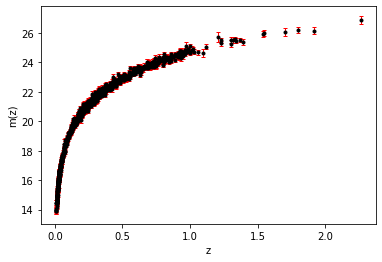

In [5]:
plt.xlabel('z')
plt.ylabel('m(z)')
plt.errorbar(z_cmb_pan, m_pan, err_pan, fmt='.', ls='', lw=1, capsize=2, c='k', ecolor='r')

**Conversion to distance modulus and luminosity distance**

Use: $\mu = m - M_B = 5\log_{10} \left(\frac{d_L}{1 Mpc} \right) +  25.$

Take (i) $M_B = -19.4$ and (ii) $M_B$ from SH0ES $\approx -19.244 $ and compare.

Plot the differences!

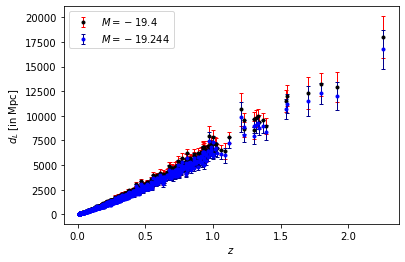

In [6]:
M = -19.4
mu = m_pan - M
dL_pan = 10**((mu - 25)/5)
errdL_pan = err_pan / 5 * np.log(10) * dL_pan

plt.errorbar(z_cmb_pan, dL_pan, errdL_pan, fmt='.', ls='', lw=1, capsize=2, c='k', ecolor='r', label='$M = -19.4$')

M2 = -19.244
mu2 = m_pan - M2
dL2_pan = 10**((mu2 - 25)/5)
errdL2_pan = err_pan / 5 * np.log(10) * dL2_pan

plt.errorbar(z_cmb_pan, dL2_pan, errdL2_pan, fmt='.', ls='', lw=1, capsize=2, c='blue', ecolor='darkblue', label='$M = -19.244$')

plt.ylabel(r"$d_L$ [in Mpc]")
plt.xlabel(r"$z$")

plt.legend()
plt.show()

**DESI BAO**

In [7]:
# DESI 2024 Y1 DATA

cov_desi = np.loadtxt("bao_data/desi_2024_gaussian_bao_ALL_GCcomb_cov.txt")

z_all_desi, mean_desi, obs_desi = np.loadtxt('bao_data/desi_2024_gaussian_bao_ALL_GCcomb_mean.txt',
                                          dtype={'names': ('z', 'value', 'quantity'),
                                                 'formats': (float, float, 'U32')}, unpack=True)

z_desi= []
DM_rd_desi = []
DH_rd_desi = [] 

z2_desi= []
DV_rd_desi = [] 

for z, value, quantity in zip(z_all_desi, mean_desi, obs_desi):
    if quantity == 'DM_over_rs':
        z_desi.append(z)
        DM_rd_desi.append(value)
    elif quantity == 'DH_over_rs':
        DH_rd_desi.append(value)

    elif quantity == 'DV_over_rs':
        DV_rd_desi.append(value)
        z2_desi.append(z)

z_desi = np.array(z_desi)
DM_rd_desi = np.array(DM_rd_desi)
DH_rd_desi = np.array(DH_rd_desi)

z2_desi = np.array(z2_desi)
DV_rd_desi = np.array(DV_rd_desi)

In [8]:
var_DM_rd_desi = []
var_DH_rd_desi = []
var_DV_rd_desi = []

for i in range(len(z_all_desi)):
    if obs_desi[i] == 'DM_over_rs':
        var_DM_rd_desi.append(np.diag(cov_desi)[i])
    if obs_desi[i] == 'DH_over_rs':
        var_DH_rd_desi.append(np.diag(cov_desi)[i])
    if obs_desi[i] == 'DV_over_rs':
        var_DV_rd_desi.append(np.diag(cov_desi)[i])
        
var_DM_rd_desi = np.array(var_DM_rd_desi)
var_DH_rd_desi = np.array(var_DH_rd_desi)
var_DV_rd_desi = np.array(var_DV_rd_desi)

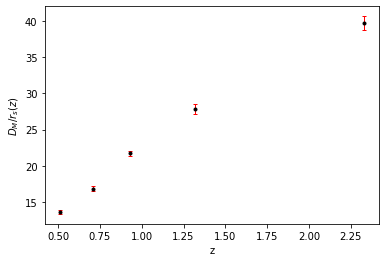

In [9]:
plt.xlabel('z')
plt.ylabel('$D_M/r_s(z)$')
plt.errorbar(z_desi, DM_rd_desi, var_DM_rd_desi**0.5, fmt='.', ls='', lw=1, capsize=2, c='k', ecolor='r')
plt.show()

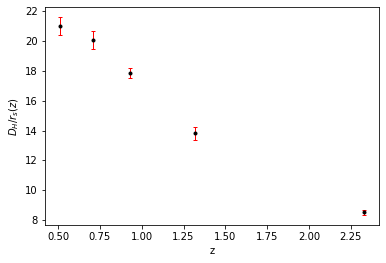

In [10]:
plt.xlabel('z')
plt.ylabel('$D_H/r_s(z)$')
plt.errorbar(z_desi, DH_rd_desi, var_DH_rd_desi**0.5, fmt='.', ls='', lw=1, capsize=2, c='k', ecolor='r')
plt.show()

**Show the Hubble parameter and Angular diameter distance at BAO  redshifts**

Use: $D_H(z) = \frac{c}{H(z)}$, and 

$D_A(z) = \frac{D_M}{(1+z)} = \frac{c}{(1+z)} \int_0^z \frac{1}{H(z)} {\rm d} z$

Take (i) $r_d$ from Planck (147.09 Mpc) and (ii) $r_d \approx$ 135 Mpc.

Plot the differences!

In [11]:
rd = 147.09
rd2 = 135

H_desi = c/(DH_rd_desi * rd)
sigH_desi = c/(DH_rd_desi * rd)**2 * var_DH_rd_desi**0.5 * rd

H2_desi = c/(DH_rd_desi * rd2)
sigH2_desi = c/(DH_rd_desi * rd2)**2 * var_DH_rd_desi**0.5 * rd2

DA_desi = DM_rd_desi * rd /(1+z_desi)
sigDA_desi = var_DM_rd_desi**0.5 * rd / (1+z_desi)

DA2_desi = DM_rd_desi * rd2 /(1+z_desi)
sigDA2_desi = var_DM_rd_desi**0.5 * rd2 / (1+z_desi)

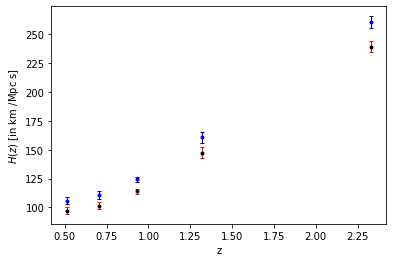

In [12]:
plt.xlabel('z')
plt.ylabel('$H(z)$ [in km /Mpc s]')
plt.errorbar(z_desi, H_desi, sigH_desi, fmt='.', ls='', lw=1, capsize=2, c='k', ecolor='r')
plt.errorbar(z_desi, H2_desi, sigH2_desi, fmt='.', ls='', lw=1, capsize=2, c='blue', ecolor='darkblue')
plt.show()

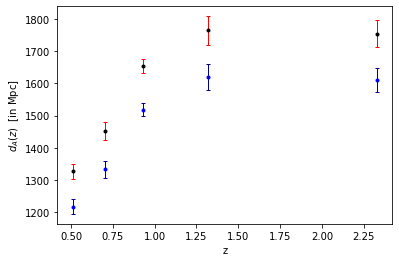

In [13]:
plt.xlabel('z')
plt.ylabel('$d_A(z)$  [in Mpc]')
plt.errorbar(z_desi, DA_desi, sigDA_desi, fmt='.', ls='', lw=1, capsize=2, c='k', ecolor='r')
plt.errorbar(z_desi, DA2_desi, sigDA2_desi, fmt='.', ls='', lw=1, capsize=2, c='blue', ecolor='darkblue')
plt.show()

# Comparison with $\Lambda$CDM

In [14]:
omega_b = 0.05
omega_c = 0.25
omega_m = omega_b + omega_c
omega_r = 9e-5
H0 = 67.4
rd = 147.09

In [15]:
class lcdm(object):
    def __init__(self, omega_m, H0, rd, omega_b=0.05, omega_r=9e-5):
        self.omega_m = float(omega_m)
        self.H0 = float(H0)
        self.rd = float(rd)
        self.omega_b = float(omega_b)
        self.omega_r = float(omega_r)

    def Ez(self, z):
        return np.sqrt(self.omega_m*(1.+z)**3. + self.omega_r*(1+z)**4 + (1.-self.omega_m-self.omega_r))

    def Hz(self,z):
        return self.H0 * self.Ez(z)

    def inv_Ez(self, z):
        return 1./self.Ez(z)

    def dMz(self, z1):
        return c/self.H0 * quad(self.inv_Ez, 0, z1)[0]

    def dAz(self, z):
        return self.dMz(z)/(1.+z)

    def dLz(self, z):
        return self.dMz(z)*(1.+z)

    def z_drag_epoch(self):         
        """ Eisenstein and Hu; arxiv:astro-ph/9709112 """
        h = self.H0/100.
        b1 = 0.313*((self.omega_m*h**2)**(-0.419))*(1+0.607*(self.omega_m*h**2)**0.674)
        b2 = 0.238*(self.omega_m*h**2)**0.223
        return 1291.*(self.omega_m*h**2)**0.251*(1+b1*(self.omega_m*h**2)**b2)/(1+0.659*(self.omega_m*h**2)**0.828)

    def sound_horizon(self, z):
        h = self.H0/100.
        Tcmb = 2.728
        R1 = 31500*(self.omega_b*h**2)*(Tcmb/2.7)**(-4)*1/(1.+z)

        def integrand1(z):
            return 1/(np.sqrt(3*(1+R1))*self.Ez(z))
        return c / self.H0*quad(integrand1, 1100, np.inf)[0]

    def t_Hub(self):
        h = self.H0/100.
        return 9.78/h

    def age_of_universe(self, z):
        integrand = lambda zz: 1./((1+zz)*self.Ez(zz))
        t0=quad(integrand,z,np.inf)[0]
        return t0*self.t_Hub()

    def dMrdz(self,z):
        return self.dMz(z)/self.rd
#        z_drag = self.z_drag_epoch()
#        return self.dMz(z)/self.sound_horizon(z_drag)

    def dHrdz(self,z):
        return c /(self.H0 * self.Ez(z)) / self.rd
#        z_drag = self.z_drag_epoch()
#        return c /(self.H0 * self.Ez(z))/self.sound_horizon(z_drag)

    def dArdz(self, z):
        return self.dAz(z)/self.rd
#        z_drag = self.z_drag_epoch()
#        return self.dAz(z)/self.sound_horizon(z_drag)

class wcdm(lcdm):
    """
    wCDM
    """
    def __init__(self, omega_m, H0, rd, w, omega_b=0.05, omega_r=9e-5):
        self.omega_m = float(omega_m)
        self.H0 = float(H0)
        self.rd = float(rd)
        self.w = float(w)
        self.omega_b = float(omega_b)
        self.omega_r = float(omega_r)

    def Ez(self, z):
        return np.sqrt(self.omega_m*(1.+z)**3. + self.omega_r*(1+z)**4 + (1.-self.omega_m-self.omega_r)*(1+z)**(3.*(1+self.w)))

**Plot the evolution of $H(z)$, $d_L(z)$, $d_M(z)$ and $d_A(z)$. Compare these with the data**

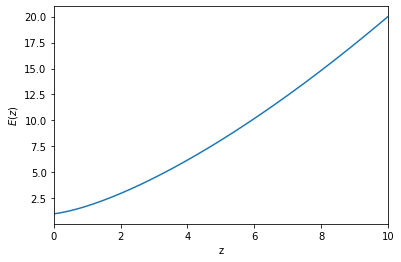

In [16]:
zz = np.linspace(0., 10., 1001)
model = lcdm(omega_m, H0, rd)

plt.xlim(0, 10.)
plt.xlabel("z")
plt.ylabel("$E(z)$")
plt.plot(zz, model.Ez(zz))
plt.show()

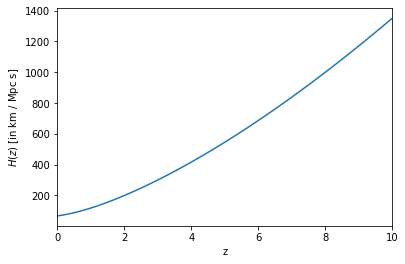

In [17]:
plt.xlim(0, 10.)
plt.xlabel("z")
plt.ylabel("$H(z)$ [in km / Mpc s]")
plt.plot(zz, model.Hz(zz))
plt.show()

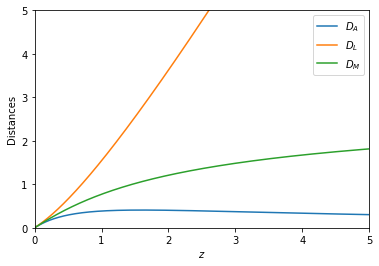

In [18]:
plt.ylim(0, 5)
plt.xlim(0, 5)
plt.xlabel("$z$")
plt.ylabel("Distances")
plt.plot(zz, [H0/c * model.dAz(z) for z in zz], label=r'$D_A$')
plt.plot(zz, [H0/c * model.dLz(z) for z in zz], label=r'$D_L$')
plt.plot(zz, [H0/c * model.dMz(z) for z in zz], label=r'$D_M$')
plt.legend()
plt.show()

**Write a similar module for the CPL dark energy parametrization:**

$w(z) = w_0 + w_a \frac{z}{1+z}$

Use $w_0$ = -0.827 and $w_a$ = -0.75.

Compare the behaviour of model with $\Lambda$CDM. Show comparison plots.

In [19]:
class cplcdm(lcdm):
    """
    CPLCDM
    """
    def __init__(self, omega_m, H0, rd, w0, wa, omega_b=0.05, omega_r=9e-5):
        self.omega_m = float(omega_m)
        self.H0 = float(H0)
        self.rd = float(rd)
        self.w0 = float(w0)
        self.wa = float(wa)
        self.omega_b = float(omega_b)
        self.omega_r = float(omega_r)

    def Ez(self, z):
        return np.sqrt(self.omega_m*(1.+z)**3. + self.omega_r*(1+z)**4 + (1.-self.omega_m-self.omega_r)*(1+z)**(3.*(1+self.w0+self.wa))*np.exp(-3.*self.wa*z/(1+z)))

In [20]:
zz = np.linspace(0., 10., 1001)
w0 = -0.827
wa = -0.75

model2 = cplcdm(omega_m, H0, rd, w0, wa)

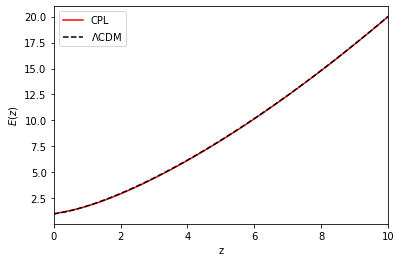

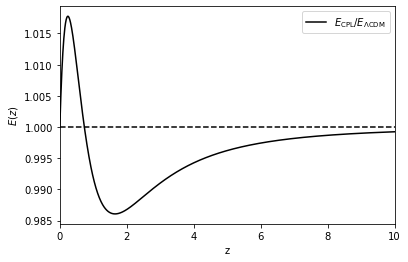

In [21]:
plt.xlim(0, 10.)
plt.xlabel("z")
plt.ylabel("$E(z)$")
plt.plot(zz, model2.Ez(zz), label='CPL', c='r', ls='-')
plt.plot(zz, model.Ez(zz), label='$\Lambda$CDM', c='k', ls='--')
plt.legend()
plt.show()

plt.xlim(0, 10.)
plt.xlabel("z")
plt.ylabel("$E(z)$")
plt.axhline(1, c='k', ls='--')
plt.plot(zz, model2.Ez(zz)/model.Ez(zz), label='$E_{\mathrm{CPL}}/E_{\mathrm{\Lambda CDM}}$', c='k')
plt.legend()
plt.show()

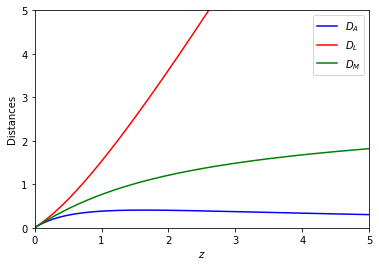

In [22]:
plt.ylim(0, 5)
plt.xlim(0, 5)
plt.xlabel("$z$")
plt.ylabel("Distances")
plt.plot(zz, [H0/c * model2.dAz(z) for z in zz], label=r'$D_A$', c='b')
plt.plot(zz, [H0/c * model2.dLz(z) for z in zz], label=r'$D_L$', c='r')
plt.plot(zz, [H0/c * model2.dMz(z) for z in zz], label=r'$D_M$', c='g')

# plt.plot(zz, [H0/c * model.dAz(z) for z in zz], label=r'$D_A$', c='b', ls='--')
# plt.plot(zz, [H0/c * model.dLz(z) for z in zz], label=r'$D_L$', c='r', ls='--')
# plt.plot(zz, [H0/c * model.dMz(z) for z in zz], label=r'$D_M$', c='g', ls='--')

plt.legend()
plt.show()

# Working with CLASS

In [23]:
directory = "class_public"
repo_url = "https://github.com/lesgourg/class_public.git"

if not os.path.isdir(directory):
    print(f"Directory {directory} does not exist. Cloning repository...")
    try:
        result = subprocess.run(["git", "clone", repo_url], check=True, capture_output=True, text=True)
        print(result.stdout)
        print(f"Repository cloned successfully into {directory}.")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while cloning the repository: {e.stderr}")
else:
    print(f"Directory {directory} already exists.")

Directory class_public already exists.


**Installing CLASS**

Open Terminal:

$ cd class_public

$ make -j // PYTHON=python3 make -j

$ cd python

$ python setup.py build

$ python setup.py install --user

In [24]:
workdir = os.getcwd()

os.chdir("class_public")
#!make -j
!PYTHON=python3 make -j

os.chdir("python")
!python3 setup.py build
#!python3 python/setup.py install
!python3 setup.py install --user
os.chdir(workdir)

cd python; export CC=gcc; output=$(python3 -m pip install . 2>&1); \
    echo "$output"; \
    if echo "$output" | grep -q "ERROR: Cannot uninstall"; then \
        site_packages=$(python3 -c "import distutils.sysconfig; print(distutils.sysconfig.get_python_lib())" || python3 -c "import site; print(site.getsitepackages()[0])") && \
	echo "Cleaning up previous installation in: $site_packages" && \
        rm -rf $site_packages/classy* && \
        python3 -m pip install .; \
    fi
Processing /home/purba/Downloads/icts_iagrg3_school_2024/Florian/Tutorials/class_public/python
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for classy: filename=classy-3.2.5-cp38-cp38-linux_x86_64.whl size=5844623 sha256=702cb8199123dc82489db1edcebeb457aa6cb56320ed5f91c8be70d4c8abb111
  Stored in directory: /tmp/pip-ephem-wheel-cache-c_w7z0ae/wheels/1b/b4/c1/0eb378d3aeeb9dd51a676b0078048a0361363dab34ac909ef5
Successfully built classy
  A

In [25]:
import classy
classy.__version__

'v3.2.5'

In [26]:
from classy import Class

In [27]:
LCDM = Class()
LCDM.set({'Omega_cdm':0.25,'Omega_b':0.05,'H0':67.4})
LCDM.compute()

In [28]:
H0_lcdm = LCDM.Hubble(0)*c
Hz_lcdm = []

for i in range(len(zz)):
    Hz_lcdm.append(LCDM.Hubble(zz[i])*c)

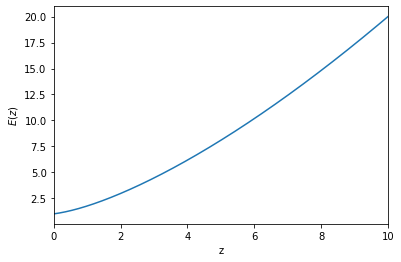

In [29]:
plt.xlim(0., 10.)
plt.xlabel("z")
plt.ylabel("$E(z)$")
plt.plot(zz, np.array(Hz_lcdm)/H0_lcdm)

plt.show()

In [30]:
zz = np.linspace(0, 2.5, 101)
dLz_lcdm = []
for i in range(len(zz)):
    dLz_lcdm.append(LCDM.luminosity_distance(zz[i]) * H0 / c)

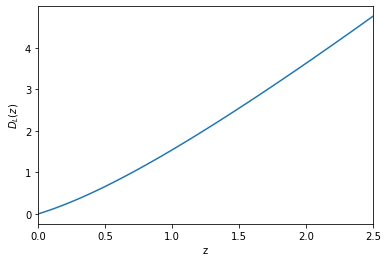

In [31]:
plt.xlim(0., 2.5)
plt.xlabel("z")
plt.ylabel("$D_L(z)$")
plt.plot(zz, np.array(dLz_lcdm))

plt.show()

**Similarly, plot the evolution of $H(z)$, $d_L(z)$, $d_M(z)$ and $d_A(z)$. Compare them with the previous LCDM module. Do you notice any differences ?**

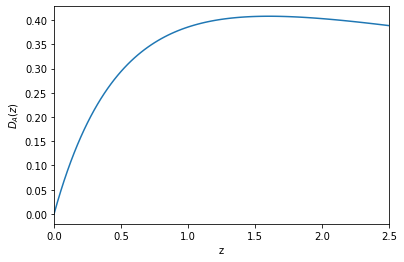

In [32]:
plt.xlim(0., 2.5)
zz = np.linspace(0, 2.5, 101)
dAz_lcdm = []
for i in range(len(zz)):
    dAz_lcdm.append(LCDM.angular_distance(zz[i]) * H0 / c)

plt.xlabel("z")
plt.ylabel("$D_A(z)$")
plt.plot(zz, np.array(dAz_lcdm))

plt.show()

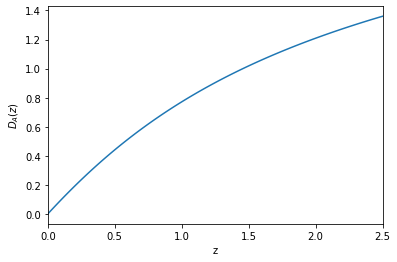

In [33]:
plt.xlim(0., 2.5)
dMz_lcdm = np.array(dAz_lcdm) * (1+zz)
plt.xlabel("z")
plt.ylabel("$D_A(z)$")
plt.plot(zz, dMz_lcdm)

plt.show()

**Do the same exercise for CPL dark energy parametrization:**

The CPL DE model is already defined in CLASS. You need to use the following flag: 

'Omega_Lambda':0

'fluid_equation_of_state':'CLP', 

'w0_fld':-0.827,

'wa_fld':-0.75

In [34]:
CPL = Class()
CPL.set({'Omega_Lambda':0.,'Omega_cdm':0.25,'Omega_b':0.05,'H0':67.4,'w0_fld':-0.827,'wa_fld':-0.75,'fluid_equation_of_state':'CLP'})
CPL.compute()

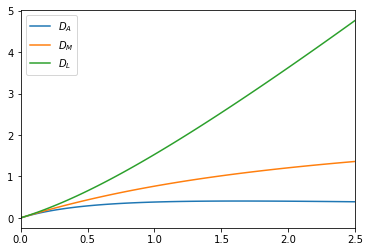

In [35]:
dA_cpl = []

for i in range(len(zz)):
    dA_cpl.append(CPL.angular_distance(zz[i]) * H0 / c)
    
dA_cpl = np.array(dA_cpl)
dL_cpl = dA_cpl * (1+zz)**2
dM_cpl = dA_cpl * (1+zz)

plt.xlim(0, 2.5)
plt.plot(zz, dA_cpl, label='$D_A$')
plt.plot(zz, dM_cpl, label='$D_M$')
plt.plot(zz, dL_cpl, label='$D_L$')
plt.legend()
plt.show()

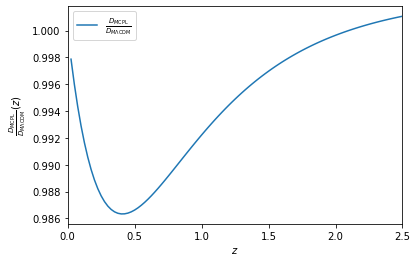

In [36]:
plt.xlim(0.0, 2.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\frac{{D_M}_{\mathrm{CPL}}}{{D_M}_{\Lambda \mathrm{CDM}}}(z)$')
plt.plot(zz[1:], dM_cpl[1:]/dMz_lcdm[1:], label=r'$\frac{{D_M}_{\mathrm{CPL}}}{{D_M}_{\Lambda \mathrm{CDM}}}$')
plt.legend()
plt.show()

**1. Compute age of the Universe**

In [37]:
age_lcdm = LCDM.age()
print(age_lcdm)

age_cpl = CPL.age()
print(age_cpl)

13.980563381806341
13.964031784908675


In [38]:
age_model = model.age_of_universe(0)
print(age_model)

age_model2 = model2.age_of_universe(0)
print(age_model2)

13.983665365669935
13.967132206069765


**2. Get angular diameter distance variation as a function of $\Omega_m$**

In [39]:
om_vals = np.linspace(0.1, 0.9, 9)
da_dict = {}
da_vals = []

for i in range(len(om_vals)):
    da_vals = []  
    for j in range(len(zz)):
        M = Class()
        M.set({'Omega_cdm':om_vals[i]-0.05,'Omega_b':0.05,'H0':67.4})
        M.compute()
        da_vals.append(M.angular_distance(zz[j])) #* H0 / c)  
        
    da_dict[i] = np.array(da_vals)
    M.struct_cleanup()
    M.empty()    

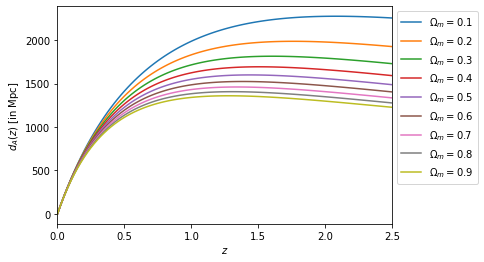

In [40]:
for i in range(len(om_vals)):
#    plt.plot(zz, da_dict[i], c='k', alpha=0.1 * i, label=f'$\Omega_m = {om_vals[i]:.2f}$')
    plt.plot(zz, da_dict[i], label=f'$\Omega_m = {om_vals[i]:.1f}$')
plt.xlim(0, 2.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$d_A(z)$ [in Mpc]')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
plt.show()

**3. Calculate the deceleration of the Universe given baseline cosmology with Planck 2018 best fits**

$q(z) = \frac{\ddot{a}}{aH^2}$

In [41]:
M = Class()
M.set({'Omega_cdm':0.25,'Omega_b':0.05,'H0':67.4})
M.compute()

In [42]:
H0_lcdm = M.Hubble(0)*c
Hz_lcdm = []

for i in range(len(zz)):
    Hz_lcdm.append(M.Hubble(zz[i])*c)
    
Hz_lcdm = np.array(Hz_lcdm)

In [43]:
M2 = Class()
M2.set({'Omega_Lambda':0.,'Omega_cdm':0.25,'Omega_b':0.05,'H0':67.4,'w0_fld':-0.827,'wa_fld':-0.75,'fluid_equation_of_state':'CLP'})
M2.compute()

H0_cpl = M2.Hubble(0)*c
Hz_cpl = []

for i in range(len(zz)):
    Hz_cpl.append(M2.Hubble(zz[i])*c)
    
Hz_cpl = np.array(Hz_cpl)

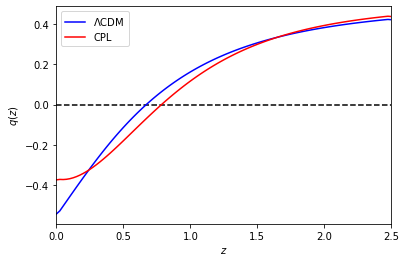

In [44]:
qz_lcdm = -1. + (1+zz)*np.gradient(Hz_lcdm, zz)/Hz_lcdm
qz_cpl = -1. + (1+zz)*np.gradient(Hz_cpl, zz)/Hz_cpl

plt.xlim(0, 2.5)

plt.xlabel(r'$z$')
plt.ylabel(r'$q(z)$')

plt.axhline(0, c= 'k', ls='--')

plt.plot(zz, qz_lcdm, c='b', label = r'$\Lambda$CDM')
plt.plot(zz, qz_cpl, c='r', label = r'CPL')
plt.legend()

# Markov Chain Monte Carlo

In [45]:
ncpu = cpu_count()
#print(f"{ncpu} CPUs available")

os.environ["OMP_NUM_THREADS"] = str(min(32, ncpu))

print(f"OMP_NUM_THREADS set to: {os.environ['OMP_NUM_THREADS']}")

OMP_NUM_THREADS set to: 8


In [46]:
def chisqr_pan(omega_m, H0, M):
    mu = m_pan - M
    cosmo = lcdm(omega_m, H0, rd)
    x = np.vectorize(cosmo.dLz) 
    mod = 5.*np.log10(x(z_cmb_pan))+25.
    delta = mu - mod
    residuals = la.solve_triangular(cov_pan, delta,lower=True,check_finite=False)
    return (residuals**2).sum() 

In [47]:
def chi_M_prior(M):
    """Gaussian prior on supernova absolute magnitude M."""
    M_prior = -19.2435 
    sigM_prior = 0.0373
    return np.sum((M - M_prior)**2 / sigM_prior**2)

In [48]:
def chi_H0_prior(M):
    """Gaussian prior on H0."""

    return 

In [49]:
def chisqr_tot(theta):
    omega_m, H0, M = theta
    return chisqr_pan(omega_m, H0, M) #+ chi_M_prior(M)

In [50]:
def lnlike(theta):
    omega_m, H0, M = theta
    return -0.5*chisqr_tot(theta)

def lnprior(theta):
    omega_m, H0, M = theta
    if 0. < omega_m < 1. and 50. < H0 < 110 and -21. < M < -18.:
        return 0.0
    return -np.inf

def lnprob(theta):
    omega_m, H0, M = theta
    lp = lnprior(theta)
    ll = lnlike(theta)
    if not np.isfinite(lp):
        return -np.inf
    elif np.isnan(ll):
        return -np.inf
    elif np.iscomplex(ll):
        return -np.inf
    else:
        return lp + ll

In [51]:
# Find the maximum likelihood value.

x0 = [0.3, 70., -19.4]
p0 = np.array(x0)
#print(chisqr_tot(x0))

In [52]:
result = opt.minimize(chisqr_tot, x0, bounds=[[0.,1.],[60., 90.],[-21, -18.]])
omega_m_ml, H0_ml, M_ml = result['x']

print("""Maximum likelihood result:
#    omega_m = {0}(truth: {1})
#    H0      = {2} (truth: {3})
#    M       = {4} (truth: {5})""".format(omega_m_ml, 0.3, H0_ml, 0.7, M_ml, -19.4))

Maximum likelihood result:
#    omega_m = 0.3174533088897638(truth: 0.3)
#    H0      = 69.70084693956933 (truth: 0.7)
#    M       = -19.353499689528142 (truth: -19.4)


# Set up the sampler.
ndim, nwalkers = 3, 10

npoints = 2000
burnin = 500

pos0 = np.array(x0)
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

pool = multiprocessing.Pool()
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)

pos, prob, state  = sampler.run_mcmc(pos, burnin, progress=True)
sampler.reset()
    
start = time.time()
pos, prob, state  = sampler.run_mcmc(pos, npoints, progress=True)
end = time.time()
multi_time = end - start

#print("Multiprocessing took {0:.1f} seconds".format(multi_time))

samples = sampler.flatchain
print(samples.shape)

af = sampler.acceptance_fraction
print(" Mean Acceptance fraction : ", af.mean())

f_out = open('lcdm_sn.txt', 'w')
np.savetxt('lcdm_sn.txt', samples)

#f_out = open('lcdm_sn_Mprior.txt', 'w')
#np.savetxt('lcdm_sn_Mprior.txt', samples)
f_out.close()

In [53]:
samples = np.loadtxt("lcdm_sn.txt")
#samples = np.loadtxt("lcdm_sn_Mprior.txt")

In [54]:
from IPython.display import display, Math

names = [r'\Omega_m', r'H_0', r'M']
ndim = len(names)

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

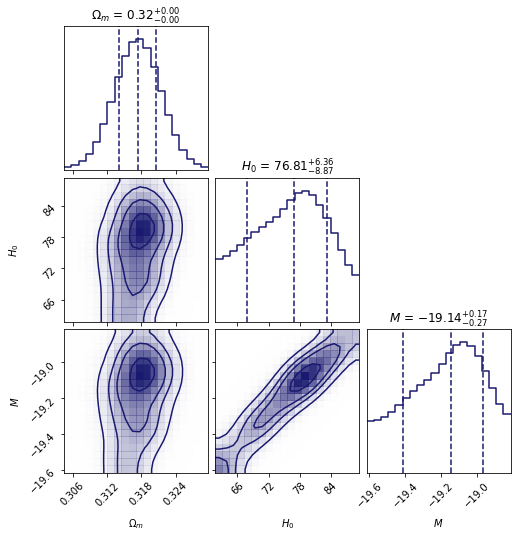

In [55]:
# Make the triangle plot.

fig = corner.corner(samples, labels=[r'$\Omega_m$', r'$H_0$', r'$M$'], quantiles=[0.16,0.5,0.84], show_titles=True, smooth=2, smooth1d=2, plot_datapoints=False, bins=20, color='midnightblue')
#fig.savefig("triangle_lcdm.pdf")
plt.show()

**You can also use GetDist for plotting**

https://getdist.readthedocs.io/en/latest/plot_gallery.html

**1. Do the exercise with the SH0ES $M_B$ or $H_0$ prior**

**2. Plot the evolution for $H(z)$, $d_L(z)$ and $q(z)$**

**3. Compute the Gaussian Tension metric between Planck $H_0$ and SH0ES**

The Gaussian Tension metric is defined as:

$T = \frac{\vert{H_0^{\rm SH0ES} - H_0^{\rm Planck}}\vert}{\sqrt{{{\sigma_{H_0}^{\rm SH0ES}}^2 + {\sigma_{H_0}^{\rm Planck}}}^2}}$

**4. What happens in the presence of curvature? Constrain $\Omega_k - \Omega_m$**

**5. Constraints on the dark energy EoS parameters when assuming CPL parameterization?**

# **Try out this exercise with the DESI BAO data**